In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Данные константы
k = 0.011  # (Вт/см/K)
c = 1.6  # (Дж/см3/K)
alpha = 0.005  # (Вт/см2/K)
l = 0.5  # длина цилиндра (см)
radius = 4  # радиус (см)
beta = 0.008  # (1/см)
t = 180  # время наблюдения (c)
u0 = 0  # температура окружающей среды (K)

In [3]:
# Задаем число отсчетов и шаги
num_m = 10
num_i = 10
tau = t/num_m # шаг по времени
h = radius/num_i # шаг по координате r
r_arr = np.linspace(0,radius,num_i) # массив точек распредленных [0,R]
t_arr = np.linspace(0,t, num_m)
w = np.zeros((num_i, num_m))

In [4]:
import scipy.optimize
def bessel(x):
    return scipy.special.jv(1,x)
res = scipy.optimize.root(bessel, 3.8) # нахождение нуля функции в окрестности точки x = 3.8
mu1 = float(res.get('x'))  # первый нуль функции бесселя первого порядка

In [5]:
mu1

3.831705970207512

In [6]:
def intensive(i): # интенсивность в i-ой точке
    return scipy.special.jv(0, mu1*i*h/radius)

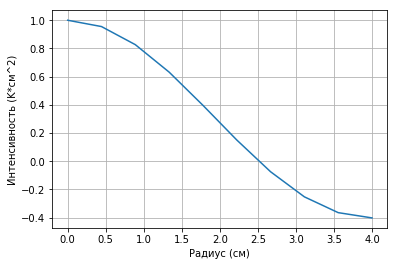

In [7]:
plt.plot(r_arr,scipy.special.jv(0, mu1*r_arr/radius)) #нарисуем интенсивность
plt.ylabel('Интенсивность (K*см^2)')
plt.xlabel('Радиус (см)')
plt.grid(True) 
plt.show()

In [8]:
# определим коэффициенты для матрицы P
a_p = c/tau+2*k/h**2+alpha/l
b_p = -2*k/h**2
def c_p(i):
    return -k/(2*h**2) + k/(4*h*i*h)
d_p = c/tau + k/h**2 + alpha/l
def e_p(i):
    return -k/(2*h**2) - k/(4*h*i*h)
f_p = -k/h**2
g_p = c/tau + k/h**2 + alpha/l

In [9]:
# определим коэффициенты для матрицы Q
a_q = c/tau - 2*k/h**2 - alpha/l
b_q = 2*k/h**2
def c_q(i):
    return k/(2*h**2) - k/(4*h*i*h)
d_q = c/tau - k/h**2 - alpha/l
def e_q(i):
    return k/(2*h**2) + k/(4*h*i*h)
f_q = k/h**2
g_q = c/tau - k/h**2 - alpha/l

In [10]:
# Заполняем матрицу P
P = np.zeros((num_i, num_i))
P[0,0] = a_p
P[0,1] = b_p
for i in range(1,num_i-1):  # по всем индексам кроме нулевого и последнего
    P[i,i-1] = c_p(i)
    P[i,i] = d_p
    P[i,i+1] = e_p(i)
P[-1,-2] = f_p
P[-1,-1] = g_p

In [11]:
# Заполняем матрицу Q
Q = np.zeros((num_i, num_i))
Q[0,0] = a_q
Q[0,1] = b_q
for i in range(1,num_i-1):  # по всем индексам кроме нулевого и последнего
    Q[i,i-1] = c_q(i)
    Q[i,i] = d_q
    Q[i,i+1] = e_q(i)
Q[-1,-2] = f_q
Q[-1,-1] = g_q

In [12]:
# краевое условие
w[:,0] = 0 # при t = 0

In [13]:
# Определим неоднородную часть
q = np.zeros((1,num_i))
for i in range(num_i):
    q[0,i] = beta/l*intensive(i)
q = q.reshape(num_i,-1) # делаем вектор-столбец

In [14]:
# Вычисляем w[i,m]
for m in range(0,num_m-1): # идем послойно, по времени
    right_column = Q@(w[:,m].reshape(num_i,-1))+q # внутри скобок делаем вектор-столбец
    w[:,m+1] = np.linalg.solve(P,right_column)[:,0]

In [15]:
v = w + u0

In [16]:
# вспомогательная функция, вылезшая в процесее аналитического решения
k1 = k*(mu1/radius)**2 + 2*alpha/l
k1

0.030093854816460174

In [17]:
# только в этой и предыдущей ячейке мы вычисляем аналитическое решение
w_analit = np.zeros((num_i, num_m))
for i in range(num_i):
    for m in range(num_m):
        time = m*tau
        r_coordinate = i*h
        w_analit[i,m] = beta/l/k1*(1-np.exp(-k1/c*time))*scipy.special.jv(0,mu1*r_coordinate/radius)
v_analit = w_analit + u0

In [18]:
# # это необходимо, чтобы все рисунки были отрисованы в одном масштабе
# min_max_v = (np.min(v), np.max(v))
# min_max_v

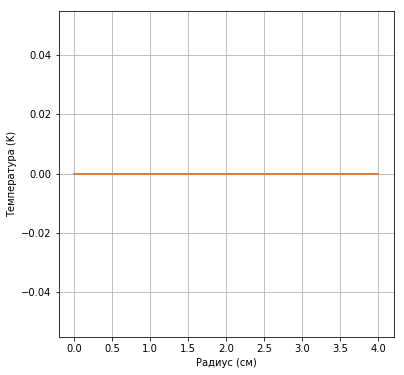

In [19]:
plt.figure(figsize=(6, 6))
plt.plot(r_arr,v[:,0]) # распредление по радиусу в начальный момент времени
plt.plot(r_arr,v_analit[:,0]) # распредление по радиусу в начальный момент времени
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Радиус (см)')
plt.grid(True)
plt.show()

In [20]:
import os
try:
    os.mkdir("num_i="+str(num_i)+" num_m="+str(num_m))
except:
    pass

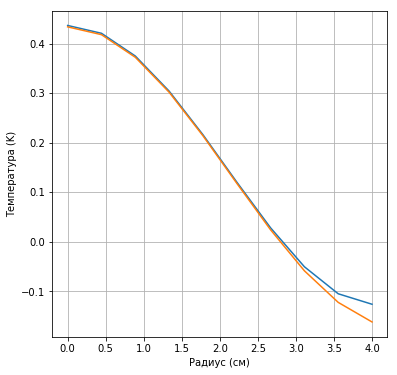

In [21]:
plt.figure(figsize=(6, 6))
plt.plot(r_arr,v[:,num_m//2]) # распредление по радиусу во время 0,5t
plt.plot(r_arr,v_analit[:,num_m//2]) # распредление по радиусу во время 0,5t
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Радиус (см)')
plt.grid(True)
plt.savefig("num_i="+str(num_i)+" num_m="+str(num_m)+"/Распредление по радиусу во время 0,5t")
plt.show()

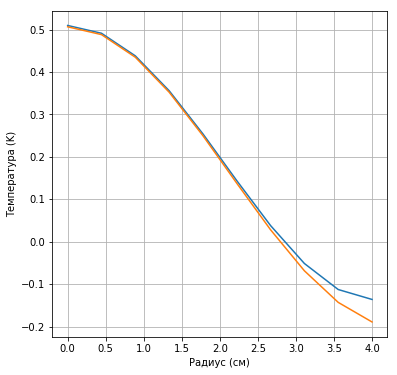

In [22]:
plt.figure(figsize=(6, 6))
plt.plot(r_arr,v[:,num_m-1]) # распредление по радиусу во время последнего отсчета по времени (уже стационарное состояние)
plt.plot(r_arr,v_analit[:,num_m-1]) # распредление по радиусу во время последнего отсчета по времени (уже стационарное состояние)
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Радиус (см)')
plt.grid(True) 
plt.show()

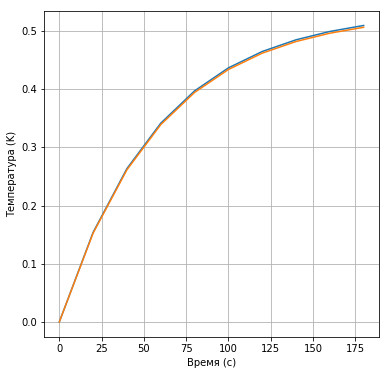

In [23]:
plt.figure(figsize=(6, 6))
plt.plot(t_arr,v[0,:]) # распредление по времени во точке r = 0
plt.plot(t_arr,v_analit[0,:]) # распредление по времени во точке r = 0
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Время (с)')
plt.grid(True) 
plt.show()

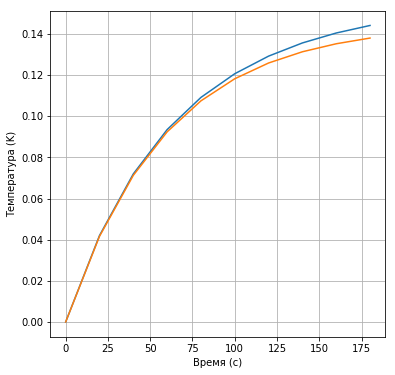

In [24]:
plt.figure(figsize=(6, 6))
plt.plot(t_arr,v[num_i//2,:]) # распредление по времени во точке r = R/2
plt.plot(t_arr,v_analit[num_i//2,:]) # распредление по времени во точке r = R/2
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Время (с)')
plt.grid(True)
plt.savefig("num_i="+str(num_i)+" num_m="+str(num_m)+"/Распредление по времени во точке r = 0,5R")
plt.show()

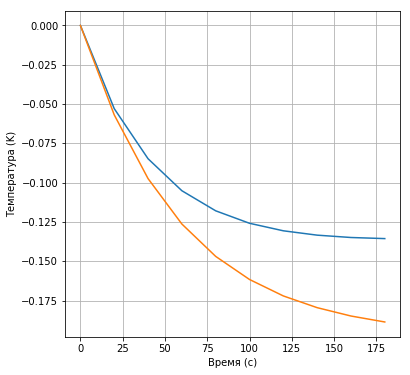

In [25]:
plt.figure(figsize=(6, 6))
plt.plot(t_arr,v[-1,:]) # распредление по времени во точке r = R
plt.plot(t_arr,v_analit[-1,:]) # распредление по времени во точке r = R
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Время (с)')
plt.grid(True) 
plt.show()

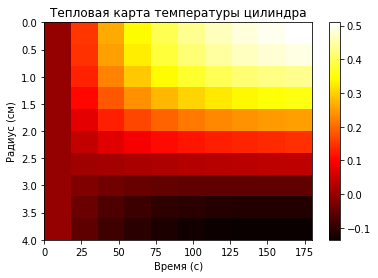

In [26]:
import matplotlib.cm as cmap
extent = [np.min(t_arr), np.max(t_arr), np.max(r_arr), np.min(r_arr)]
plt.imshow(v, cmap=cmap.hot, aspect='auto', extent=extent)
plt.title("Тепловая карта температуры цилиндра")
plt.ylabel('Радиус (см)')
plt.xlabel('Время (с)')
plt.colorbar()
plt.show()

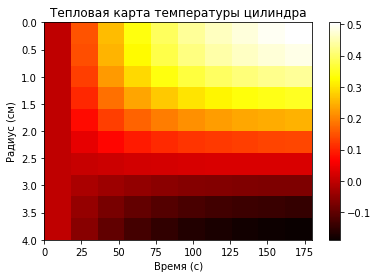

In [27]:
import matplotlib.cm as cmap
extent = [np.min(t_arr), np.max(t_arr), np.max(r_arr), np.min(r_arr)]
plt.imshow(v_analit, cmap=cmap.hot, aspect='auto', extent=extent)
plt.title("Тепловая карта температуры цилиндра")
plt.ylabel('Радиус (см)')
plt.xlabel('Время (с)')
plt.colorbar()
plt.show()